## This is Assingment 2 Task 1
For task 1 the objective is to implement a Set Abstract Data Type, were implementing *Element*, *build(X)* in *O(n lg n)*, and *find(k)*, *insert(x)*, *delete(k)*, *find_min()*, *find_max()*, *find_prev(k)*, *find_next(k)* in *O(lg n)*. Were also tasked with justifying the runtime complexity through algorithm analysis or testing in **Task 1 b**

### Task 1 a

In [18]:
import random, time, math, statistics
from __future__ import annotations
from dataclasses import dataclass
from typing import Any, Optional, Iterable, Tuple
import matplotlib.pyplot as plt

In [3]:
@dataclass(frozen=True)
class Element:
    k: int
    data: Any

In [2]:
class Node:
    def __init__(self, k: int, data: Any):
        self.k = k
        self.data = data
        self.left: Optional[Node] = None
        self.right: Optional[Node] = None
        self.height = 1

In [ ]:
class AVLSet:
    def __init__(self):
        self._root: Optional[Node] = None
        self._size = 0
        self.steps = 0
        self.rotations = 0

    # ---------- Public API ----------

    def build(self, X: Iterable[Element]) -> None:
        """O(n log n) build by repeated insert."""
        self._root = None
        self._size = 0
        for e in X:
            self.insert(e)

    def find(self, k: int) -> Tuple[Optional[int], Optional[Any], bool]:
        n = self._root
        while n is not None:
            self.steps += 1
            if k == n.k:
                return n.k, n.data, True
            n = n.left if k < n.k else n.right
        return None, None, False

    def insert(self, x: Element) -> None:
        before = self._size
        self._root = self._insert(self._root, x.k, x.data)

    def delete(self, k: int) -> None:
        self._root = self._delete(self._root, k)

    def find_min(self) -> Tuple[Optional[int], Optional[Any], bool]:
        n = self._min_node(self._root)
        if n is None:
            return None, None, False
        return n.k, n.data, True

    def find_max(self) -> Tuple[Optional[int], Optional[Any], bool]:
        n = self._max_node(self._root)
        if n is None:
            return None, None, False
        return n.k, n.data, True

    def find_prev(self, k: int) -> Tuple[Optional[int], Optional[Any], bool]:
        n = self._successor(self._root, k)
        if n is None:
            return None, None, False
        return n.k, n.data, True

    def find_next(self, k: int) -> Tuple[Optional[int], Optional[Any], bool]:
        n = self._predecessor(self._root, k)
        if n is None:
            return None, None, False
        return n.k, n.data, True

    def __len__(self) -> int:
        return self._size
    
    def reset_counters(self):
        self.steps = 0
        self.rotations = 0

    # ---------- AVL internals ----------

    def _h(self, n: Optional[Node]) -> int:
        return n.height if n is not None else 0

    def _update(self, n: Node) -> None:
        n.height = 1 + max(self._h(n.left), self._h(n.right))

    def _bf(self, n: Node) -> int:
        return self._h(n.left) - self._h(n.right)

    def _rotate_right(self, y: Node) -> Node:
        self.rotations += 1
        x = y.left
        assert x is not None
        T2 = x.right

        x.right = y
        y.left = T2

        self._update(y)
        self._update(x)
        return x

    def _rotate_left(self, x: Node) -> Node:
        self.rotations += 1
        y = x.right
        assert y is not None
        T2 = y.left

        y.left = x
        x.right = T2

        self._update(x)
        self._update(y)
        return y

    def _rebalance(self, n: Node) -> Node:
        self._update(n)
        bf = self._bf(n)

        # Left heavy
        if bf > 1:
            # Left-Right case
            if n.left is not None and self._bf(n.left) < 0:
                n.left = self._rotate_left(n.left)
            return self._rotate_right(n)

        # Right heavy
        if bf < -1:
            # Right-Left case
            if n.right is not None and self._bf(n.right) > 0:
                n.right = self._rotate_right(n.right)
            return self._rotate_left(n)

        return n

    def _insert(self, n: Optional[Node], k: int, data: Any) -> Node:
        if n is None:
            self._size += 1
            return Node(k, data)

        self.steps += 1
        if k == n.k:
            # Set semantics: do nothing if exists
            return n
        elif k < n.k:
            n.left = self._insert(n.left, k, data)
        else:
            n.right = self._insert(n.right, k, data)

        return self._rebalance(n)

    def _delete(self, n: Optional[Node], k: int) -> Optional[Node]:
        if n is None:
            return None

        self.steps += 1
        if k < n.k:
            n.left = self._delete(n.left, k)
        elif k > n.k:
            n.right = self._delete(n.right, k)
        else:
            # Found node to delete
            if n.left is None and n.right is None:
                self._size -= 1
                return None
            if n.left is None:
                self._size -= 1
                return n.right
            if n.right is None:
                self._size -= 1
                return n.left

            # Two children: swap with successor (min in right subtree)
            succ = self._min_node(n.right)
            assert succ is not None
            n.k, n.data = succ.k, succ.data
            # delete successor key from right subtree
            n.right = self._delete(n.right, succ.k)

        return self._rebalance(n)

    def _min_node(self, n: Optional[Node]) -> Optional[Node]:
        cur = n
        while cur is not None and cur.left is not None:
            self.steps += 1
            cur = cur.left
        if cur is not None:
            self.steps += 1
        return cur

    def _max_node(self, n: Optional[Node]) -> Optional[Node]:
        cur = n
        while cur is not None and cur.right is not None:
            self.steps += 1
            cur = cur.right
        if cur is not None:
            self.steps += 1
        return cur

    def _successor(self, n: Optional[Node], k: int) -> Optional[Node]:
        """Smallest key strictly greater than k."""
        cur = n
        succ = None
        while cur is not None:
            self.steps += 1
            if k < cur.k:
                succ = cur
                cur = cur.left
            else:
                cur = cur.right
        return succ

    def _predecessor(self, n: Optional[Node], k: int) -> Optional[Node]:
        """Largest key strictly less than k."""
        cur = n
        pred = None
        while cur is not None:
            self.steps += 1
            if k > cur.k:
                pred = cur
                cur = cur.right
            else:
                cur = cur.left
        return pred

### Task 1b justification of runtime complexity

In [ ]:
# ----------------------------
# Helpers (data + plotting)
# ----------------------------

def make_unique_keys(n: int, seed: int) -> list[int]:
    rng = random.Random(seed)
    return rng.sample(range(1, 10*n + 1), n)

def mean(xs):
    return sum(xs) / len(xs) if xs else 0.0

def eval_op(ns, op_name, op_func, normalize=None, trials=15):
    avg_steps = []
    avg_rots = []

    for n in ns:
        steps_trials = []
        rots_trials = []
        for t in range(trials):
            steps, rots = op_func(n, seed=10000*n + t)
            steps_trials.append(steps)
            rots_trials.append(rots)

        s = mean(steps_trials)
        r = mean(rots_trials)

        if normalize is not None:
            denom = normalize(n)
            s = s / denom if denom != 0 else s

        avg_steps.append(s)
        avg_rots.append(r)

    return {"n": ns, "steps": avg_steps, "rots": avg_rots, "name": op_name}

def plot_curves(curves, title, ylabel, logx=True):
    plt.figure()
    for c in curves:
        plt.plot(c["n"], c["steps"], marker="o", label=c["name"])
    if logx:
        plt.xscale("log", base=2)
    plt.xlabel("n")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# ----------------------------
# Operation evaluators
# Each returns (steps_used, rotations_used)
# ----------------------------

def op_build(n: int, seed: int):
    keys = make_unique_keys(n, seed)
    elems = [Element(k, None) for k in keys]
    S = AVLSet()
    S.reset_counters()
    S.build(elems)
    return S.steps, S.rotations

def op_find_hit(n: int, seed: int, qcount=5000):
    keys = make_unique_keys(n, seed)
    elems = [Element(k, None) for k in keys]
    S = AVLSet()
    S.build(elems)

    rng = random.Random(seed + 1)
    queries = [keys[rng.randrange(n)] for _ in range(qcount)]

    S.reset_counters()
    for k in queries:
        S.find(k)
    return (S.steps / qcount), (S.rotations / qcount)

def op_find_miss(n: int, seed: int, qcount=5000):
    keys = make_unique_keys(n, seed)
    elems = [Element(k, None) for k in keys]
    S = AVLSet()
    S.build(elems)

    # choose misses outside key range
    queries = [10*n + 100000 + i for i in range(qcount)]

    S.reset_counters()
    for k in queries:
        S.find(k)
    return (S.steps / qcount), (S.rotations / qcount)

def op_insert_new(n: int, seed: int, qcount=3000):
    keys = make_unique_keys(n, seed)
    elems = [Element(k, None) for k in keys]
    S = AVLSet()
    S.build(elems)

    new_keys = [10*n + 100000 + i for i in range(qcount)]

    S.reset_counters()
    for k in new_keys:
        S.insert(Element(k, None))
    return (S.steps / qcount), (S.rotations / qcount)

def op_delete_hit(n: int, seed: int, qcount=3000):
    keys = make_unique_keys(n, seed)
    elems = [Element(k, None) for k in keys]
    S = AVLSet()
    S.build(elems)

    rng = random.Random(seed + 2)
    del_keys = [keys[rng.randrange(n)] for _ in range(qcount)]

    S.reset_counters()
    for k in del_keys:
        S.delete(k)
    return (S.steps / qcount), (S.rotations / qcount)

def op_find_min(n: int, seed: int, qcount=5000):
    keys = make_unique_keys(n, seed)
    elems = [Element(k, None) for k in keys]
    S = AVLSet()
    S.build(elems)

    S.reset_counters()
    for _ in range(qcount):
        S.find_min()
    return (S.steps / qcount), (S.rotations / qcount)

def op_find_max(n: int, seed: int, qcount=5000):
    keys = make_unique_keys(n, seed)
    elems = [Element(k, None) for k in keys]
    S = AVLSet()
    S.build(elems)

    S.reset_counters()
    for _ in range(qcount):
        S.find_max()
    return (S.steps / qcount), (S.rotations / qcount)

def op_find_prev_successor(n: int, seed: int, qcount=5000):
    keys = make_unique_keys(n, seed)
    elems = [Element(k, None) for k in keys]
    S = AVLSet()
    S.build(elems)

    rng = random.Random(seed + 3)
    queries = [keys[rng.randrange(n)] for _ in range(qcount)]

    S.reset_counters()
    for k in queries:
        S.find_prev(k)
    return (S.steps / qcount), (S.rotations / qcount)

def op_find_next_predecessor(n: int, seed: int, qcount=5000):
    keys = make_unique_keys(n, seed)
    elems = [Element(k, None) for k in keys]
    S = AVLSet()
    S.build(elems)

    rng = random.Random(seed + 4)
    queries = [keys[rng.randrange(n)] for _ in range(qcount)]

    S.reset_counters()
    for k in queries:
        S.find_next(k)
    return (S.steps / qcount), (S.rotations / qcount)


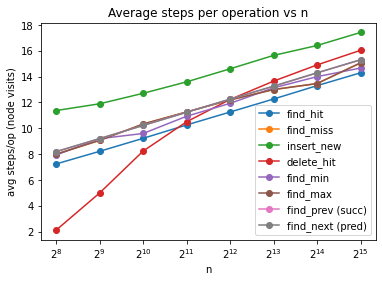

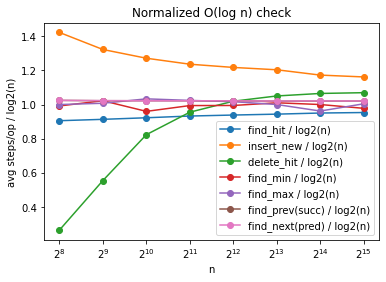

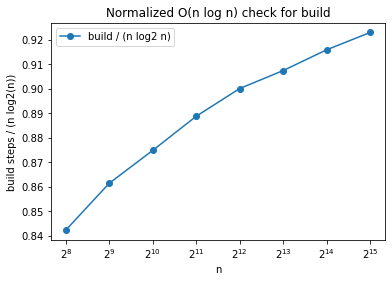

In [20]:
# ----------------------------
# Run evaluation + graphs
# ----------------------------

ns = [2**k for k in range(8, 16)]  # 256..32768
trials = 15

# Raw (average steps per op)
raw_curves = [
    eval_op(ns, "find_hit", op_find_hit, trials=trials),
    eval_op(ns, "find_miss", op_find_miss, trials=trials),
    eval_op(ns, "insert_new", op_insert_new, trials=trials),
    eval_op(ns, "delete_hit", op_delete_hit, trials=trials),
    eval_op(ns, "find_min", op_find_min, trials=trials),
    eval_op(ns, "find_max", op_find_max, trials=trials),
    eval_op(ns, "find_prev (succ)", op_find_prev_successor, trials=trials),
    eval_op(ns, "find_next (pred)", op_find_next_predecessor, trials=trials),
]
plot_curves(raw_curves, "Average steps per operation vs n", "avg steps/op (node visits)")

# Normalized O(log n): steps/log2(n) should be ~flat
norm_log = lambda n: math.log2(n)
log_curves = [
    eval_op(ns, "find_hit / log2(n)", op_find_hit, normalize=norm_log, trials=trials),
    eval_op(ns, "insert_new / log2(n)", op_insert_new, normalize=norm_log, trials=trials),
    eval_op(ns, "delete_hit / log2(n)", op_delete_hit, normalize=norm_log, trials=trials),
    eval_op(ns, "find_min / log2(n)", op_find_min, normalize=norm_log, trials=trials),
    eval_op(ns, "find_max / log2(n)", op_find_max, normalize=norm_log, trials=trials),
    eval_op(ns, "find_prev(succ) / log2(n)", op_find_prev_successor, normalize=norm_log, trials=trials),
    eval_op(ns, "find_next(pred) / log2(n)", op_find_next_predecessor, normalize=norm_log, trials=trials),
]
plot_curves(log_curves, "Normalized O(log n) check", "avg steps/op / log2(n)")

# Build: total steps / (n log2(n)) should be ~flat
norm_nlogn = lambda n: n * math.log2(n)
build_curve = [eval_op(ns, "build / (n log2 n)", op_build, normalize=norm_nlogn, trials=trials)]
plot_curves(build_curve, "Normalized O(n log n) check for build", "build steps / (n log2(n))")